<a href="https://colab.research.google.com/github/ryota0051/nishika-sake/blob/main/notebooks/03_distance_learning%20/google_colabo/02_efficientnet_v2_large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Sep 11 12:19:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install faiss-gpu
!pip install japanize_matplotlib
!pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'
!pip install timm
!pip install transformers
!pip install albumentations
!pip install pytorch-metric-learning
# !pip install https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=d40b7b3e74c38381a7010786cbf6fac01bf9a5d881a9b239bb8a01589b7a9b62
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib
  Cloning https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to /tmp/pip-req-build-kgjjl4pp
  Running command git clone --filter=blob:none --quiet https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup /tmp/pip-req-build-kgjjl4pp
  Resolved https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to commit 12d03c07553aedd3d9e9155e2b3e31ce8c64081a
  Preparing metadata (setup.py) ... done
  Created wheel for cosine-annealing-warmup: fi

In [3]:
!git clone https://github.com/ryota0051/nishika-sake

Cloning into 'nishika-sake'...
remote: Enumerating objects: 264, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 264 (delta 0), reused 0 (delta 0), pack-reused 257
Receiving objects: 100% (264/264), 86.59 MiB | 24.63 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [ ]:
!ls /content/drive/MyDrive/competition/nishika_sake

inputs	intermidiates  notebooks  outputs  submissions


In [ ]:
!ls

drive  nihshika-sake  sample_data


## 概要

- efficientnetv2 large(gloval_average_pooling => gemに変更) + arcface を用いて meigara の予測 タスクを実行
- 学習済みモデルを用いて test, cite の画像の embedding を取得し、それらの距離から類似画像を選択
- 回転

## Library

In [4]:
import datetime
import gc
import itertools
import json
import logging
import os
import shutil
import math
from pathlib import Path
import sys

import albumentations as A
import cv2
import japanize_matplotlib
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F

from albumentations import ImageOnlyTransform
from albumentations.pytorch import ToTensorV2
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from torch.cuda.amp import GradScaler, autocast
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
    MultiStepLR,
    ReduceLROnPlateau,
)
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup
from torch.utils.tensorboard import SummaryWriter
import faiss
from pytorch_metric_learning import losses

sys.path.append('./nishika-sake')
from src.searcher import SimilaritySearcher
from src.const import OUTPUT_ROOT, DATA_ROOT, QUERY_IMAGES_PATH, CITE_IMAGES_PATH
from src.layer import GeM
from src.layer.elastic_face import ElasticCosFace
from src.layer.arcface import ArcMarginProduct
from src.utils import seed_torch, mrr_at_k_by_searched_index

In [ ]:
timm.list_models('*efficient*', pretrained=True)

['efficientformer_l1.snap_dist_in1k',
 'efficientformer_l3.snap_dist_in1k',
 'efficientformer_l7.snap_dist_in1k',
 'efficientformerv2_l.snap_dist_in1k',
 'efficientformerv2_s0.snap_dist_in1k',
 'efficientformerv2_s1.snap_dist_in1k',
 'efficientformerv2_s2.snap_dist_in1k',
 'efficientnet_b0.ra_in1k',
 'efficientnet_b1.ft_in1k',
 'efficientnet_b1_pruned.in1k',
 'efficientnet_b2.ra_in1k',
 'efficientnet_b2_pruned.in1k',
 'efficientnet_b3.ra2_in1k',
 'efficientnet_b3_pruned.in1k',
 'efficientnet_b4.ra2_in1k',
 'efficientnet_b5.sw_in12k',
 'efficientnet_b5.sw_in12k_ft_in1k',
 'efficientnet_el.ra_in1k',
 'efficientnet_el_pruned.in1k',
 'efficientnet_em.ra2_in1k',
 'efficientnet_es.ra_in1k',
 'efficientnet_es_pruned.in1k',
 'efficientnet_lite0.ra_in1k',
 'efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k',
 'efficientvit_b0.r224_in1k',
 'efficientvit_b1.r224_in1k',
 'efficientvit_b1.r256_in1k',
 'efficientvit_b1.r288_in1k',
 'efficientvit_b2.r224_i

## Config

In [ ]:
class Config:
    competition = "sake"
    name = "efficientnetv2_l"

    debug = False
    use_amp = True

    training = True
    evaluation = True
    embedding = True
    embedding_dim = 1024
    use_plus = True
    s = 30
    m = 0.35

    seed = 8823
    n_fold = 3
    trn_fold = [
        0,
        1,
        2,3,
        4
    ]

    target_columns = ["meigara_label"]
    size = 448

    model_name = "tf_efficientnetv2_l.in21k_ft_in1k"
    max_epochs = 5
    train_batch_size = 12
    valid_batch_size = 100
    num_workers = 4
    gradient_accumulation_steps = 1
    clip_grad_norm = 1000
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    optimizer = dict(
        optimizer_name="AdamW",
        lr=1e-4,
        weight_decay=1e-2,
        eps=1e-6,
        beta=(0.9, 0.999),
        encoder_lr=1e-4,
        decoder_lr=1e-4,
    )

    scheduler = dict(
        scheduler_name="cosine",
        num_warmup_steps_rate=0.1,
        num_cycles=0.5,
    )
    batch_scheduler = True


if Config.debug:
    Config.max_epochs = 2
    Config.n_fold = 2
    Config.trn_fold = [0, 1]
    Config.name = Config.name + "_debug"

## Const

In [ ]:
HOME = Path("/content/drive/MyDrive/competition/nishika_sake")
NOTEBOOK_NAME = requests.get("http://172.28.0.12:9000/api/sessions").json()[0]["name"][:-6]
EXP_NAME = Config.name if Config.name is not None else NOTEBOOK_NAME
INPUTS = HOME / "inputs"  # input data
OUTPUTS = HOME / "outputs"
INTERMIDIATES = HOME / "intermidiates"  # intermidiate outputs
SUBMISSIONS = HOME / "submissions"
OUTPUTS_EXP = OUTPUTS / EXP_NAME
EXP_MODELS = OUTPUTS_EXP / "models"
EXP_REPORTS = OUTPUTS_EXP / "reports"
EXP_PREDS = OUTPUTS_EXP / "predictions"
SCRIPTS = HOME / "scripts"

CITE_IMAGES = Path("cite_images")
QUERY_IMAGES = Path("query_images")

## Setup

In [ ]:
def setup(Config):

    for d in [
        HOME,
        INPUTS,
        SUBMISSIONS,
        EXP_MODELS,
        EXP_REPORTS,
        EXP_PREDS,
        INTERMIDIATES,
    ]:
        d.mkdir(parents=True, exist_ok=True)

def check_file_exists(folder_path, file_name):
    folder = Path(folder_path)
    for file_path in folder.glob("**/*"):
        if file_path.is_file() and file_path.stem == file_name:
            return True
    return False


def create_new_datasets_in_kaggle(dataset_name, upload_dir):
    from kaggle.api.kaggle_api_extended import KaggleApi

    dataset_metadata = {}
    dataset_metadata["id"] = f'{os.environ["KAGGLE_USERNAME"]}/{dataset_name}'
    dataset_metadata["licenses"] = [{"name": "CC0-1.0"}]
    dataset_metadata["title"] = dataset_name
    with open(os.path.join(upload_dir, "dataset-metadata.json"), "w") as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode="tar")


class Logger:
    def __init__(self, path):
        self.general_logger = logging.getLogger(path)
        stream_handler = logging.StreamHandler()
        file_general_handler = logging.FileHandler(os.path.join(path, "Experiment.log"))
        if len(self.general_logger.handlers) == 0:
            self.general_logger.addHandler(stream_handler)
            self.general_logger.addHandler(file_general_handler)
            self.general_logger.setLevel(logging.INFO)

    def info(self, message):
        # display time
        self.general_logger.info("[{}] - {}".format(self.now_string(), message))

    @staticmethod
    def now_string():
        return str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


def copy_file(source_file, destination_file):
    try:
        shutil.copy(source_file, destination_file)
        print("copy complete")
    except IOError as e:
        print(f"copy error: {e}")

In [ ]:
setup(Config)
LOGGER = Logger(OUTPUTS_EXP.as_posix())

In [ ]:
# content 直下で解凍 (ターミナルで実行が良さそう)
if not QUERY_IMAGES.is_dir():
    query_images = (INPUTS / "query_images.zip").as_posix()
    ! cp $query_images .
    # ! cp /content/drive/MyDrive/competition/nishika_sake/inputs/query_images.zip .
    ! unzip ./query_images.zip

if not CITE_IMAGES.is_dir():
    cite_images = (INPUTS / "cite_images.zip").as_posix()
    ! cp $cite_images .
    # ! cp /content/drive/MyDrive/competition/nishika_sake/inputs/cite_images.zip .
    ! unzip ./cite_images.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: cite_images/100029442.jpg  
  inflating: cite_images/100077258.jpg  
  inflating: cite_images/100019581.jpg  
  inflating: cite_images/100068378.jpg  
  inflating: cite_images/100036562.jpg  
  inflating: cite_images/100082979.jpg  
  inflating: cite_images/100070537.jpg  
  inflating: cite_images/100041932.jpg  
  inflating: cite_images/100039651.jpg  
  inflating: cite_images/100028984.jpg  
  inflating: cite_images/100007967.jpg  
  inflating: cite_images/100071629.jpg  
  inflating: cite_images/100046085.jpg  
  inflating: cite_images/100069066.jpg  
  inflating: cite_images/100066355.jpg  
  inflating: cite_images/100020300.jpg  
  inflating: cite_images/100105802.jpg  
  inflating: cite_images/100093874.jpg  
  inflating: cite_images/100056296.jpg  
  inflating: cite_images/100079275.jpg  
  inflating: cite_images/100030113.jpg  
  inflating: cite_images/100076146.jpg  
  inflating: cite_images/100039889.jpg  
  inflating: cite_images/

## Load data

In [ ]:
def make_train_label(train_df) -> pd.DataFrame:
    le = LabelEncoder()
    train_df["brand_id_label"] = le.fit_transform(train_df["brand_id"])
    train_df["meigara_label"] = le.fit_transform(train_df["meigara"])

    return train_df


def make_filepath(input_df):
    def join_path(dirpath, filename):
        return (dirpath / filename).as_posix()

    output_df = input_df.assign(
        filepath=input_df["filename"].apply(
            lambda x: join_path(QUERY_IMAGES, x) if str(x)[0] == "2" else join_path(CITE_IMAGES, x)
        )
    )
    return output_df

def make_label_dict(train_df):
    MLABEL2MEIGARA = train_df[["meigara", "meigara_label"]].set_index("meigara_label").to_dict()["meigara"]
    BLABEL2BLAND = train_df[["brand_id", "brand_id_label"]].set_index("brand_id_label").to_dict()["brand_id"]
    return MLABEL2MEIGARA, BLABEL2BLAND

In [ ]:
# load raw data
train_df = pd.read_csv(INPUTS / "train.csv")
test_df = pd.read_csv(INPUTS / "test.csv")
cite_df = pd.read_csv(INPUTS / "cite.csv").rename(columns={"cite_gid":"gid", "cite_filename":"filename"})
sample_submission_df = pd.read_csv(INPUTS / "sample_submission.csv")

if Config.debug:
    train_df = train_df.sample(1000, random_state=Config.seed).reset_index(drop=True)
    cite_df = cite_df.sample(100, random_state=Config.seed).reset_index(drop=True)

# make label
train_df = make_train_label(train_df)
MLABEL2MEIGARA, BLABEL2BLAND = make_label_dict(train_df)
Config.num_classes = len(MLABEL2MEIGARA)

# make filepath
train_df = make_filepath(train_df)
test_df = make_filepath(test_df)
cite_df = make_filepath(cite_df)

# for submission
IDX2CITE_GID = cite_df.to_dict()["gid"]

print(train_df.shape)

(108160, 7)


## CV Split

In [ ]:
def add_fold_idx(config, train_df):
    fold = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)
    train_df["fold"] = -1
    for i_fold, (train_index, val_index) in enumerate(
        fold.split(train_df, train_df[config.target_columns])
    ):
        train_df.iloc[val_index, train_df.columns.get_loc("fold")] = int(i_fold)
    train_df["fold"] = train_df["fold"].astype(int)
    return train_df

In [ ]:
train_df = add_fold_idx(config=Config, train_df=train_df)
train_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


,gid,filename,brand_id,meigara,brand_id_label,meigara_label,filepath,fold
0,200000001,200000001.jpg,3372,五橋,2211,445,query_images/200000001.jpg,2
1,200000002,200000002.jpg,3751,庭のうぐいす,2454,1122,query_images/200000002.jpg,2
2,200000003,200000003.jpg,2856,笑四季,1864,1819,query_images/200000003.jpg,1
3,200000004,200000004.jpg,1527,鍋島,1005,2263,query_images/200000004.jpg,0
4,200000005,200000005.jpg,2676,仙禽,1739,478,query_images/200000005.jpg,1


## Dataset

In [ ]:
class TrainDataset(Dataset):
    def __init__(self,df, target_columns=Config.target_columns, transform_fn=None):
        self.df = df
        self.file_names = df["filepath"].to_numpy()
        self.targets = df[target_columns].to_numpy()
        if len(target_columns) == 1:
            self.targets = np.ravel(self.targets)

        self.transform_fn = transform_fn

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filepath = self.file_names[idx]
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform_fn:
            image = self.transform_fn(image=image)["image"]
        target = torch.tensor(self.targets[idx])
        return {"images":image, "targets":target}


class TestDataset(Dataset):
    def __init__(self, df, transform_fn=None):
        self.df = df
        self.file_names = df["filepath"].to_numpy()
        self.transform_fn = transform_fn

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filepath = self.file_names[idx]
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform_fn:
            image = self.transform_fn(image=image)["image"]
        return {"images":image}

## Transforms

In [ ]:
def set_transform(dataset, transform):
    if isinstance(dataset, torch.utils.data.Subset):
        set_transform(dataset.dataset, transform)
    else:
        dataset.transform_fn = transform


def get_transforms(size, data="train", p=0.5):

    if data == 'train':
        return A.Compose([
            # 正方形切り出し
            A.RandomResizedCrop(size, size, scale=(0.85, 1.0)),
            A.OneOf(
                transforms=[
                    A.augmentations.geometric.rotate.SafeRotate(
                        limit=(-45, -90),
                    ),
                    A.augmentations.geometric.rotate.SafeRotate(
                        limit=(45, 90),
                    )
                ],
                p=p
            ),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(size, size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

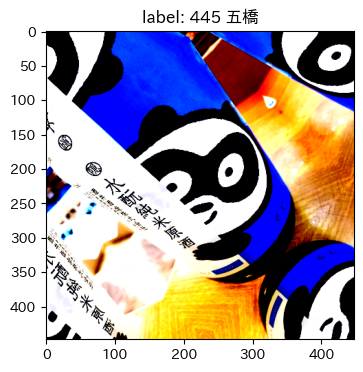

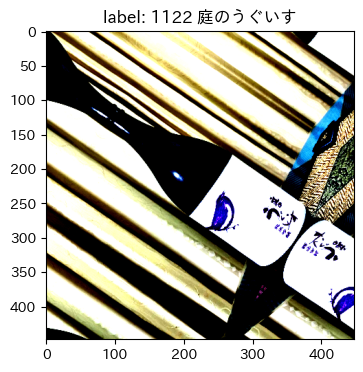

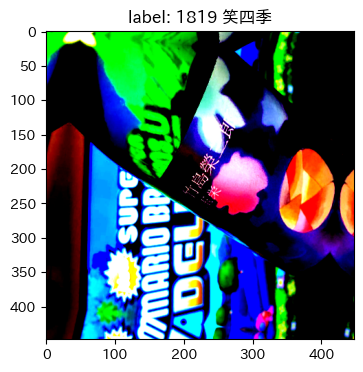

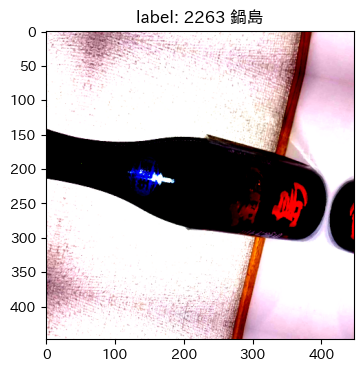

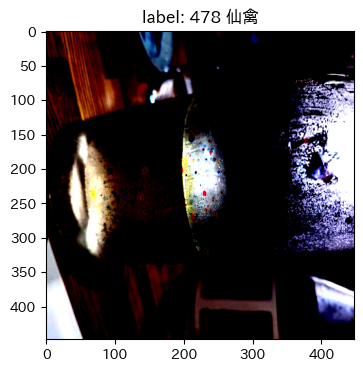

In [ ]:
train_dataset = TrainDataset(df=train_df, transform_fn=get_transforms(data="train", size=Config.size, p=0))
japanize_matplotlib.japanize()
train_dataloader = DataLoader(
    train_dataset,
    batch_size=Config.train_batch_size,
    shuffle=False,
    num_workers=Config.num_workers,
    pin_memory=True,
    drop_last=True,
)
set_transform(train_dataset, get_transforms(data='train', size=Config.size, p=1))
for batch in train_dataloader:
    break
image, label = batch["images"].numpy().transpose(0, 2, 3, 1),  batch["targets"].numpy()
for i in range(5):
    plt.figure(figsize=(4, 4))
    plt.imshow(image[i])
    plt.title(f"label: {int(label[i])} {MLABEL2MEIGARA[int(label[i])]}")
    plt.show()

## Model

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, config, pretrained=False):
        super().__init__()
        self.config = config
        self.model = timm.create_model(
            self.config.model_name,
            pretrained=pretrained,
            features_only=True
        )
        self.n_features = self.model.feature_info[-1]['num_chs']
        self.global_pool = GeM()
        self.fc = nn.Linear(self.n_features, config.embedding_dim)
        self.out = ElasticCosFace(
            config.embedding_dim,
            config.num_classes,
            plus=config.use_plus,
            s=config.s,
            m=config.m
        )

    def forward(self, x, label):
        x = self.extract_features(x)
        x = self.out(x, label)
        return x

    def extract_features(self, images, labels=None):
        bs = images.size(0)
        x = self.model(images)[-1]
        x = self.global_pool(x).view(bs, -1)
        x = self.fc(x)
        return x

In [ ]:
model = CustomModel(Config, pretrained=True).cuda()
outputs = model(torch.rand(2, 3, Config.size, Config.size).cuda(), torch.tensor([1, 1]).cuda())
outputs.size()

torch.Size([2, 464])

## Funcs

In [ ]:
def train_fn(
    config,
    model,
    dataloader,
    criterion,
    optimizer,
    scheduler,
    _custom_step,
):
    model.train()
    scaler = torch.cuda.amp.GradScaler(init_scale=256, enabled=config.use_amp)
    losses = []

    tbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, batch in tbar:
        for k, v in batch.items():
            batch[k] = v.to(config.device)
        targets = batch["targets"]
        batch_size = targets.size(0)

        with torch.cuda.amp.autocast(enabled=config.use_amp):
            batch_outputs = model(batch["images"], label=batch["targets"])
            loss = criterion(batch_outputs, targets)

        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps

        scaler.scale(loss).backward()
        if config.clip_grad_norm is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_grad_norm)
            torch.nn.utils.clip_grad_norm_(criterion.parameters(), config.clip_grad_norm)

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            _custom_step += 1
            if config.batch_scheduler:
                scheduler.step()

        losses.append(float(loss) * config.gradient_accumulation_steps)
        tbar.set_description(f"loss: {np.mean(losses) :.4f} lr: {scheduler.get_lr()[0]:.6f}")

    loss = np.mean(losses)
    return loss, _custom_step


def extract_features(model, data_loader, device):
    preds, targets = [], []
    model.eval()
    tbar = tqdm(data_loader, total=len(data_loader))
    for batch in tbar:
        for k, v in batch.items():
            batch[k] = v.to(device)
        with torch.no_grad():
            outputs = model.extract_features(batch['images'])
        outputs = outputs.cpu().detach().numpy()
        target_labels = batch['targets'].cpu().detach().numpy()
        preds.append(outputs)
        targets.append(target_labels)
    return np.concatenate(preds), np.concatenate(targets)

In [ ]:
def get_optimizer(optimizer_config, params):
    if optimizer_config["optimizer_name"] == "AdamW":
        optimizer = AdamW(
            params,
            lr=optimizer_config["lr"],
            betas=optimizer_config["beta"],
            eps=optimizer_config["eps"],
        )
        return optimizer
    else:
        raise NotImplementedError


def get_scheduler(scheduler_config, optimizer, num_train_steps):
    if scheduler_config["scheduler_name"] == "linear":
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(scheduler_config["num_warmup_steps_rate"] * num_train_steps),
            num_training_steps=num_train_steps,
        )
        return scheduler

    elif scheduler_config["scheduler_name"] == "cosine":
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(scheduler_config["num_warmup_steps_rate"] * num_train_steps),
            num_training_steps=num_train_steps,
            num_cycles=scheduler_config["num_cycles"],
        )
        return scheduler

    elif scheduler_config["scheduler_name"] == "cosine_restarts":
        """
        example:
            first_cycle_steps_ratio = 0.25,
            cycle_mult = 1.0,
            max_lr = 2e-5,
            min_lr = 1e-7,
            warmup_steps=100,
            gamma=0.8)
        """
        scheduler = CosineAnnealingWarmupRestarts(
            optimizer,
            first_cycle_steps=int(num_train_steps * scheduler_config["first_cycle_steps_ratio"]),
            cycle_mult=scheduler_config["cycle_mult"],
            max_lr=scheduler_config["max_lr"],
            min_lr=scheduler_config["min_lr"],
            warmup_steps=scheduler_config["warmup_steps"],
            gamma=scheduler_config["gamma"],
        )
        return scheduler

    else:
        raise NotImplementedError

In [ ]:
def get_probability_by_epoch(epoch: int):
    return 2 ** (- epoch)


def train_loop(config, name, train_df, index_df, query_df, criterion):
    LOGGER.info(f"========== {name} training ==========")

    # dataloader
    train_dataloader, index_dataloader, query_dataloader = get_dl(
        train_df,
        index_df,
        query_df,
        config,
        epoch=1
    )

    # set model & optimizer
    model = CustomModel(config, pretrained=True)
    model.to(config.device)
    criterion.to(config.device)
    params = [
        {'params': model.parameters()},
        {'params': criterion.parameters()}
    ]
    optimizer = get_optimizer(optimizer_config=config.optimizer, params=params)

    # set scheduler
    num_train_steps = int(
        len(train_dataloader) * config.max_epochs // config.gradient_accumulation_steps
    )
    scheduler = get_scheduler(
        scheduler_config=config.scheduler, optimizer=optimizer, num_train_steps=num_train_steps
    )

    # loop
    best_mrr = -np.inf
    tr_step, val_step = 0, 0
    for epoch in range(Config.max_epochs):
        train_dataloader, index_dataloader, query_dataloader = get_dl(
            train_df,
            index_df,
            query_df,
            config,
            epoch+1
        )
        LOGGER.info(train_dataloader.dataset.transform_fn)
        # training
        loss, tr_step = train_fn(
            config=config,
            model=model,
            dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            _custom_step=tr_step,
        )
        torch.cuda.empty_cache()
        gc.collect()

        # validation
        index_preds, index_targets = extract_features(model, index_dataloader, config.device)
        query_preds, query_targets = extract_features(model, query_dataloader, config.device)
        searcher = SimilaritySearcher(index_preds)
        _, I = searcher.search(query_preds)
        mrr = mrr_at_k_by_searched_index(query_targets, index_targets, I)

        logs = {
            "Epoch": epoch,
            "train_loss_epoch": loss.item(),
            "valid_mrr": mrr,
        }
        LOGGER.info(logs)

        if mrr > best_mrr:
            best_mrr = mrr
            LOGGER.info(f"epoch {epoch} - best mrr: {best_mrr:.4f} model")

            torch.save(model.state_dict(), f"{name}.pth")  # save model weight

        if not config.batch_scheduler:
            scheduler.step()

    torch.cuda.empty_cache()
    gc.collect()

    # to escape drive storage error
    copy_file(f"{name}.pth", EXP_MODELS / f"{name}.pth")

    return best_mrr

def get_dl(train_df, index_df, query_df, config=Config, epoch=1):
    assert epoch != 0
    train_dataset = TrainDataset(
        df=train_df,
        target_columns=config.target_columns,
        transform_fn=get_transforms(data="train", size=config.size, p=get_probability_by_epoch(epoch))
    )
    index_dataset = TrainDataset(
        df=index_df,
        target_columns=config.target_columns,
        transform_fn=get_transforms(data="valid", size=config.size)
    )
    query_dataset = TrainDataset(
        df=query_df,
        target_columns=config.target_columns,
        transform_fn=get_transforms(data="valid", size=config.size)
    )
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config.train_batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    index_dataloader = DataLoader(
        index_dataset,
        batch_size=config.valid_batch_size,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )
    query_dataloader = DataLoader(
        query_dataset,
        batch_size=config.valid_batch_size,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )
    return train_dataloader, index_dataloader, query_dataloader


def get_index_and_query_df(base_df, target_col=Config.target_columns[0], unique_id_col='gid', seed=Config.seed):
    """index, queryに対応するデータフレームを返す
    Args:
        base_df: 分岐元データフレーム
        target_col: 目的変数絡む
        unique_id_col: ユニークなカラム名
        seed: queryを選択する際のシード値
    Returns:
        (indexデータフレーム, queryデータフレーム)
    """
    # カウント数が1より多いものをクエリー画像候補とする。
    counts_df = base_df[target_col].value_counts()
    counts_df = counts_df[counts_df != 1]
    query_candidates = base_df[base_df[target_col].isin(counts_df.index)]
    # 目的変数から各カテゴリ1つずつランダムに取得してクエリ画像とする。
    query_target_target_id_list = query_candidates.groupby(target_col).sample(
        1,
        random_state=seed)[unique_id_col].to_list()
    is_query_filter = base_df[unique_id_col].isin(query_target_target_id_list)
    return base_df[~is_query_filter], base_df[is_query_filter]

## Training
- multi class calssification

In [ ]:
seed_torch()
mrr_list = []
if Config.training:
    for i_fold in range(Config.n_fold):
        if i_fold not in Config.trn_fold:
            print(f'fold {i_fold} skipped')
            continue

        train_df_fold = train_df[train_df["fold"] != i_fold]
        valid_df_fold = train_df[train_df["fold"] == i_fold]
        index_df, query_df = get_index_and_query_df(valid_df_fold)
        criterion = nn.CrossEntropyLoss()

        summary_writer = SummaryWriter(log_dir=OUTPUTS_EXP / f'fold_{i_fold}')
        mrr_score = train_loop(
            config=Config,
            name=f"fold_{i_fold}",
            train_df=train_df_fold,
            index_df=index_df,
            query_df=query_df,
            criterion=criterion
        )
        mrr_list.append(mrr_score)
LOGGER.info(mrr_list)

[2023-09-11 12:39:16] - ========== fold_0 training ==========
INFO:/content/drive/MyDrive/competition/nishika_sake/outputs/efficientnetv2_l:[2023-09-11 12:39:16] - ========== fold_0 training ==========
[2023-09-11 12:39:21] - Compose([
  RandomResizedCrop(always_apply=False, p=1.0, height=448, width=448, scale=(0.85, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1),
  OneOf([
    SafeRotate(always_apply=False, p=0.5, limit=(-45, -90), interpolation=1, border_mode=4, value=None, mask_value=None),
    SafeRotate(always_apply=False, p=0.5, limit=(45, 90), interpolation=1, border_mode=4, value=None, mask_value=None),
  ], p=0.5),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
INFO:/content/drive/MyDrive/competition/nishika_sake/outputs/efficientnetv2_l:[2023

copy complete


[2023-09-11 20:09:35] - Compose([
  RandomResizedCrop(always_apply=False, p=1.0, height=448, width=448, scale=(0.85, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1),
  OneOf([
    SafeRotate(always_apply=False, p=0.5, limit=(-45, -90), interpolation=1, border_mode=4, value=None, mask_value=None),
    SafeRotate(always_apply=False, p=0.5, limit=(45, 90), interpolation=1, border_mode=4, value=None, mask_value=None),
  ], p=0.5),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not c

copy complete


[2023-09-12 03:44:26] - ========== fold_2 training ==========
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/p

copy complete


## Embeddings

In [ ]:
def inference_fn(test_dataloader, model, device, features=False):
    preds, targets_masks = [], []
    model.eval()
    model.to(device)

    tbar = tqdm(test_dataloader, total=len(test_dataloader))
    for batch in tbar:
        for k, v in batch.items():
            batch[k] = v.to(device)

        with torch.no_grad():
            outputs = model.extract_features(batch["images"])

        outputs = outputs.cpu().detach().numpy()
        preds.append(outputs)

    return np.concatenate(preds)


def get_features(config, test_df, model_path):
    test_dataset = TestDataset(df=test_df, transform_fn=get_transforms(data="valid", size=config.size))
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=config.valid_batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # get model
    model = CustomModel(config, pretrained=False)
    state = torch.load(model_path)
    model.load_state_dict(state)
    features = inference_fn(test_dataloader, model, config.device, features=True)

    del model, state, test_dataloader
    gc.collect()
    torch.cuda.empty_cache()

    outputs = {
        "gid": test_df["gid"].tolist(),
        "features": np.array(features, dtype=np.float16),
    }
    return outputs

In [ ]:
if Config.embedding:
    # oof
    # oof_features_filepath = EXP_PREDS / "oof_embeddings.pkl"
    # if not oof_features_filepath.is_file():
    #     oof_features, oof_gids = [], []
    #     for i_fold in range(Config.n_fold):
    #         if i_fold not in Config.trn_fold:
    #             continue

    #         gids = joblib.load(EXP_PREDS / f"fold_{i_fold}_best.pkl")["gid"]
    #         df = train_df[train_df["gid"].isin(gids)].reset_index(drop=True)

    #         outputs = get_features(
    #             config=Config,
    #             test_df=df,
    #             model_path=EXP_MODELS / f"fold_{i_fold}.pth",
    #             device=DEVICE
    #             )
    #         oof_features.append(outputs["features"])
    #         oof_gids.extend(outputs["gid"])
    #     oof_features = np.concatenate(oof_features, axis=0)
    #     joblib.dump({"gid":oof_gids, "embeddings":oof_features}, oof_features_filepath)

    # query images
    query_features_filepath = EXP_PREDS / "test_embeddings.pkl"
    if not query_features_filepath.is_file():
        query_features = []
        for i_fold in range(Config.n_fold):
            if i_fold not in Config.trn_fold:
                continue

            outputs = get_features(
                config=Config,
                test_df=test_df,
                model_path=EXP_MODELS / f"fold_{i_fold}.pth",
            )
            query_features.append(outputs["features"])
        joblib.dump({"gid":outputs["gid"], "embeddings_list":query_features}, query_features_filepath)

    # cite images
    cite_features_filepath = EXP_PREDS / "cite_embeddings.pkl"
    if not cite_features_filepath.is_file():
        cite_features = []
        for i_fold in range(Config.n_fold):
            if i_fold not in Config.trn_fold:
                continue

            outputs = get_features(
                config=Config,
                test_df=cite_df,
                model_path=EXP_MODELS / f"fold_{i_fold}.pth",
            )
            cite_features.append(outputs["features"])
        joblib.dump({"gid":outputs["gid"], "embeddings_list":cite_features}, cite_features_filepath)

100%|██████████| 1095/1095 [1:07:42<00:00,  3.71s/it]


## Similarity

In [ ]:
class SimilaritySearcher:
    def __init__(self, embeddings):
        self.dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatL2(self.dimension)
        faiss.normalize_L2(embeddings)
        self.index.add(embeddings)  # type:ignore

    def search(self, queries, k=10):
        assert queries.shape[1] == self.dimension, "Query dimensions should match embeddings dimension."
        faiss.normalize_L2(queries)
        D, I = self.index.search(queries, k)  # type:ignore
        return D, I

In [ ]:
cite_features = np.array(joblib.load(EXP_PREDS / "cite_embeddings.pkl")["embeddings_list"])
query_features = np.array(joblib.load(EXP_PREDS / "test_embeddings.pkl")["embeddings_list"])

ave_cite_feature = np.mean(cite_features, axis=0)
ave_query_feature = np.mean(query_features, axis=0)

searcher = SimilaritySearcher(ave_cite_feature.astype(np.float32))
D, I = searcher.search(ave_query_feature.astype(np.float32), k=20)

## Make submission

In [ ]:
def make_submission(indices):
    vfunc = np.vectorize(lambda x: IDX2CITE_GID[x])
    gid_array = vfunc(I)
    submission_df = test_df[["gid"]].assign(cite_gid=[" ".join(list(x)) for x in gid_array.astype(str)])
    return submission_df

In [ ]:
submission_df = make_submission(indices=I)
submission_df.to_csv(SUBMISSIONS / f"{Config.name}.csv", index=False)

## Result

In [ ]:
submission_df = pd.read_csv(SUBMISSIONS / f"{Config.name}.csv")

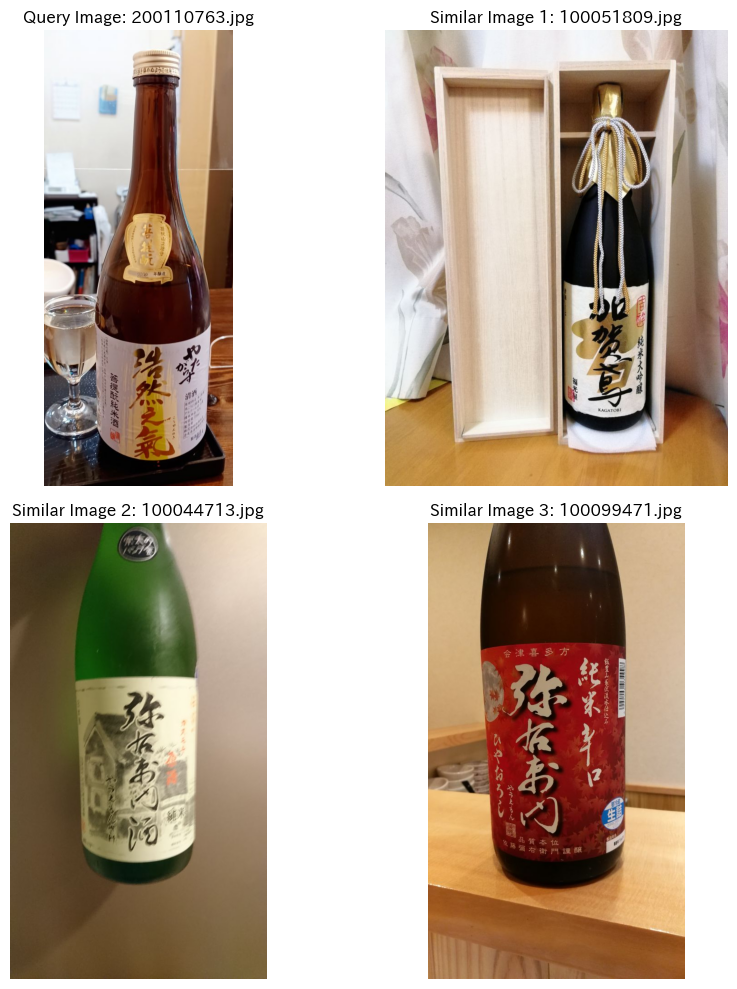

In [ ]:
import cv2
import matplotlib.pyplot as plt

def display_similar_images(query_path, cite_paths):
    num_similar = len(cite_paths)

    # Query画像の読み込み
    query_image = cv2.imread(query_path)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)

    # 類似画像の読み込みと表示
    num_rows = (num_similar + 1) // 2
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 10), squeeze=False)

    axs[0, 0].imshow(query_image)
    axs[0, 0].set_title(f'Query Image: {query_path.split("/")[-1]}')
    axs[0, 0].axis('off')

    for i, path in enumerate(cite_paths):
        similar_image = cv2.imread(path)
        similar_image = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB)

        axs[(i+1)//2, (i+1)%2].imshow(similar_image)
        axs[(i+1)//2, (i+1)%2].set_title(f'Similar Image {i+1}: {path.split("/")[-1]}')
        axs[(i+1)//2, (i+1)%2].axis('off')

    # 空白のsubplotを削除
    if num_similar % 2 != 0:
        axs[num_rows-1, 1].axis('off')

    plt.tight_layout()
    plt.show()


def get_qyery_and_cite_path(submission_df, query_gid=None, k=4):
    if query_gid is None:
        query_gid = submission_df["gid"].sample(1).to_numpy()[0]

    cites = submission_df.loc[submission_df["gid"] ==query_gid, "cite_gid"].to_numpy()[0].split(" ")[:k]

    query_path = QUERY_IMAGES / f"{query_gid}.jpg"
    cite_paths = [(CITE_IMAGES / f"{cite_gid}.jpg").as_posix() for cite_gid in cites]
    return {"query_path":query_path.as_posix(), "cite_paths":cite_paths}


def plot_sake(submission_df, query_gid=None, k=11):
    path_dict = get_qyery_and_cite_path(submission_df, query_gid=query_gid, k=k)
    display_similar_images(**path_dict)


# plot_sake(submission_df, query_gid=200108186, k=5)
plot_sake(submission_df, query_gid=None, k=3)